# Table of Contents

1. Import Libraries
2. Load Dataset
3. Preprocessing and Exploring Text Data
  
  3.1 Text Cleaning
  
  3.2 Finding Word Count

  3.3 Find and Replace Rare Words with "Unknown" Token

4. Data Preparation

  4.1 Prepare Sequences

5. Download GPT-2

6. Finetune GPT-2

7. Load a trained model checkpoints


# 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import pickle
import re
import random
from tqdm import tqdm_notebook

import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
# reproducing same results
SEED = 2019

# torch
torch.manual_seed(SEED)

# 2. Load Dataset

In [ ]:
# open text file and read in data
with open("Dailog-dataset.dialogs_dataset", "rb") as f:
  dialogs = pickle.load(f)

In [ ]:
# number of text sequences
len(dialogs)

64776

In [ ]:
# print 10 random dialogs
random.sample(dialogs, 10)

["I'd like the Cappuccino",
 'sure anything also',
 'Schedule a car for me tonight',
 "I see, that's fine then",
 'Yeah pick up',
 'Regular is just fine',
 'Do you know how long it will take for the Uber driver to get here?',
 'That sounds great',
 ' Just put in my name and it will go through',
 " Let's do a table then"]

# 3. Preprocessing and Exploring Text Data

## 3.1 Text Cleaning

In [ ]:
# text cleaning
dialogs_clean = []

for i in dialogs:
  # remove everything except alphabets
  i = re.sub("[^a-zA-Z' ]", "", i)
  # convert text to lowercase
  i = i.lower()
  # add cleaned text to the list
  dialogs_clean.append(i)

In [ ]:
random.sample(dialogs_clean, 10)

['the bruins game at the garden',
 'yes a booth would be great',
 "oh that's right just traditional crust then",
 'just forget about it',
 'can i get an olive oil drizzle along with prosciutto',
 'no we want to see imax',
 "it's a honda civic",
 'let me send her a text and see what she would prefer',
 'no just the one coffee',
 'hi i would like to order pizza please']


## 3.2 Finding Word Count

In [ ]:
# get list of all the words
all_words = " ".join(dialogs_clean).split()

words_dict = {}

# add word-count pair to the dictionary
for word in all_words:   
  # check if the word is already in dictionary 
  if word in words_dict:
    # increment count of word by 1 
    words_dict[word] = words_dict[word] + 1
  else:
    # add the word to dictionary with count 1 
    words_dict[word] = 1

In [ ]:
# prepare a dataframe
words_df = pd.DataFrame({'word':list(words_dict.keys()), 'count':list(words_dict.values())})

# sort words by their count in increasing order
words_df = words_df.sort_values(by = ['count'])

# reset dataframe index
words_df.reset_index(inplace = True, drop=True)

In [ ]:
# vocabulary size
len(words_df)

11147

In [ ]:
words_df.head()

,word,count
0,uppermiddle,1
1,shoots,1
2,geesh,1
3,andrea,1
4,precice,1


In [ ]:
words_df.tail()

,word,count
11142,you,11909
11143,a,13380
11144,to,14000
11145,the,15406
11146,i,19654


## 3.3 Find and Replace Rare Words with "Unknown" Token

In [ ]:
# user specified threshold value
rare_thresh = 4

# get percentage of rare words in the vocabulary
rare_words_count = len(words_df[words_df['count'] < rare_thresh]['word'])
total_words = len(words_df) 
rare_dist = rare_words_count / total_words

# coverage percentage of rare words in the corpus
rare_cover = words_df[words_df['count'] < rare_thresh]['count'].sum()/words_df['count'].sum()

In [ ]:
print(f"Rare words distribution in the vocabulary: {rare_dist*100:.2f}")
print(f"Rare words coverage in the corpus: {rare_cover*100:.2f}")

Rare words distribution in the vocabulary: 69.03
Rare words coverage in the corpus: 2.27


In [ ]:
# extract rare words in a list
rare_words = words_df[words_df['count'] < rare_thresh]['word'].tolist()

Let's see the technique that we will use to replace the rare words/tokens in the dataset with a special token known as the unknown token ("\<unk\>")

In [ ]:
## example
# specify rare words
r_words = ["day", "book"]

# build pattern
pattern = ""
for i in r_words:
  pattern+= "{}|".format(i)

print(pattern)

day|book|


In [ ]:
# removing the last element which is "|"
pattern = pattern[:-1]
print(pattern)

day|book


In [ ]:
# replace the rare words with the <unk> token
sents = ["it has been a long day", "this book is a must read"]

for d in sents:
  text = re.sub(pattern, " <unk> ", d)
  print(text)

it has been a long  <unk> 
this  <unk>  is a must read


In [ ]:
# create a text pattern from the rare words, like "word1 | word2 | word3..."
pattern = ""
for i in rare_words:
  pattern+= " {} |".format(i)

# removing the last element which is "|"
pattern = pattern[:-1]

# empty list 
dialogs_clean_v2 = []

# replace the rare words with the <unk> token
for d in tqdm_notebook(dialogs_clean):
  text = re.sub(pattern, " <unk> ", d)
  dialogs_clean_v2.append(text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/64776 [00:00<?, ?it/s]

In [ ]:
dialogs_clean_v2[520:530]

['does it serve traditional chinese dessert',
 'how much extra time to reach <unk> ',
 'ok lets reserve a table for dinner at hakkasan',
 'hello i need to get a car please',
 'holiday inn <unk> parkconv <unk> convention center drive <unk> park il',
 'bowling alley <unk> highway <unk> park il',
 'what types of cars does uber have',
 "what's the price difference",
 'ok get me the cheapest please',
 'ok then get me the next level']

# 4. Data Preparation

## 4.1 Prepare Sequences

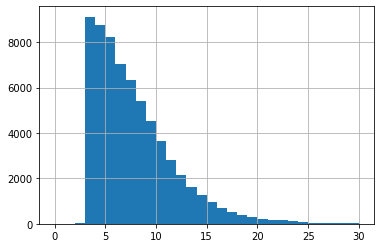

In [ ]:
# capture length of all the sequences
text_word_count = []
for i in dialogs_clean_v2:
  text_word_count.append(len(i.split()))
        
# plot the sequence lengths
pd.Series(text_word_count).hist(bins = 30,range=(0,30))

In [ ]:
# function to create sequences of equal length
def create_seq(text, seq_len = 5):
      
  sequences = []    
  
  if len(text.split()) > seq_len:
    for i in range(seq_len, len(text.split())):
      # select sequence of tokens
      seq = text.split()[i-seq_len:i+1]
      # append sequence to the list
      sequences.append(" ".join(seq))

    return sequences

  else:
    
    return [text]

In [ ]:
# create sequences of equal length
seqs = [create_seq(i) for i in dialogs_clean_v2]

In [ ]:
seqs[:10]

[["hi i'm looking to book a",
  "i'm looking to book a table",
  'looking to book a table for',
  'to book a table for korean',
  'book a table for korean fod'],
 ['somewhere in southern nyc maybe the',
  'in southern nyc maybe the east',
  'southern nyc maybe the east village'],
 ["we don't want to sit at",
  "don't want to sit at the",
  'want to sit at the bar',
  'to sit at the bar but',
  'sit at the bar but anywhere',
  'at the bar but anywhere else',
  'the bar but anywhere else is',
  'bar but anywhere else is fine'],
 ['what times are available'],
 ["yikes we can't do those times"],
 ['let me check'],
 ["great let's book that"],
 ["no that's it just book"],
 ['hi i would like to see',
  'i would like to see if',
  'would like to see if the',
  'like to see if the movie',
  'to see if the movie what',
  'see if the movie what men',
  'if the movie what men want',
  'the movie what men want is',
  'movie what men want is playing',
  'what men want is playing here'],
 ['yes for m

In [ ]:
# merge list-of-lists into a single list
seqs = sum(seqs, [])

In [ ]:
seqs[:15]

["hi i'm looking to book a",
 "i'm looking to book a table",
 'looking to book a table for',
 'to book a table for korean',
 'book a table for korean fod',
 'somewhere in southern nyc maybe the',
 'in southern nyc maybe the east',
 'southern nyc maybe the east village',
 "we don't want to sit at",
 "don't want to sit at the",
 'want to sit at the bar',
 'to sit at the bar but',
 'sit at the bar but anywhere',
 'at the bar but anywhere else',
 'the bar but anywhere else is']

In [ ]:
# count of sequences
len(seqs)

205346

In [ ]:
# create input and target sequences (x and y)
x = []
y = []

for s in seqs:
  x.append(" ".join(s.split()[:-1]))
  y.append(" ".join(s.split()[1:]))

In [ ]:
x[0], y[0]

("hi i'm looking to book", "i'm looking to book a")

In [ ]:
x[88543], y[88543]

('to drive to several locations', 'drive to several locations do')

## 4.2 Create Token-Integer Mappings

In [ ]:
# create integer-to-token mapping
int2token = {}
cnt = 1

for w in set(" ".join(dialogs_clean_v2).split()):
  int2token[cnt] = w
  cnt+= 1

# create token-to-integer mapping
token2int = {t: i for i, t in int2token.items()}

In [ ]:
token2int["can"], int2token[1127]

(4363, 'jabos')

## 4.3 Split Data into Train and Validation Sets

In [ ]:
# train-validation split
# input sequences
x_tr = x[:150000]
x_val = x[150000:]

# target sequences
y_tr = y[:150000]
y_val = y[150000:]

In [ ]:
!pip install -q gpt-2-simple
import gpt_2_simple as gpt2
from datetime import datetime
from google.colab import files

In [ ]:
!nvidia-smi

Mon Jun 27 20:49:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading GPT-2

There are three released sizes of GPT-2:

* `124M` (default): the "small" model, 500MB on disk.
* `355M`: the "medium" model, 1.5GB on disk.
* `774M`: the "large" model, cannot currently be finetuned with Colaboratory but can be used to generate text from the pretrained model
* `1558M`: the "extra large", true model. Will not work if a K80/P4 GPU is attached to the notebook.

Larger models have more knowledge, but take longer to finetune and longer to generate text. You can specify which base model to use by changing `model_name` in the cells below.


In [ ]:
gpt2.download_gpt2(model_name="124M")

Fetching checkpoint: 1.05Mit [00:00, 383Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:01, 576kit/s]
Fetching hparams.json: 1.05Mit [00:00, 591Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 498Mit [01:22, 6.06Mit/s]                                  
Fetching model.ckpt.index: 1.05Mit [00:00, 580Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:01, 878kit/s]
Fetching vocab.bpe: 1.05Mit [00:01, 756kit/s]


**Mounting Google Drive**

---



In [ ]:
gpt2.mount_gdrive()

Mounted at /content/drive


**Uploading Text File To be Trained **

---



In [ ]:
file_name = "Dailog-dataset.dialogs_dataset"

In [ ]:
gpt2.copy_file_from_gdrive(file_name)

## Finetune GPT-2

The next cell will start the actual finetuning of GPT-2. It creates a persistent TensorFlow session which stores the training config, then runs the training for the specified number of `steps`

The model checkpoints will be saved in `/checkpoint/run1` by default. The checkpoints are saved every 500 steps (can be changed) and when the cell is stopped.

The training might time out after 4ish hours; make sure you end training and save the results so you don't lose them!

*  **`restore_from`**: Set to `fresh` to start training from the base GPT-2, or set to `latest` to restart training from an existing checkpoint.
* **`sample_every`**: Number of steps to print example output
* **`print_every`**: Number of steps to print training progress.
* **`learning_rate`**:  Learning rate for the training. (default `1e-4`, can lower to `1e-5` if you have <1MB input data)
*  **`run_name`**: subfolder within `checkpoint` to save the model. This is useful if you want to work with multiple models (will also need to specify  `run_name` when loading the model)
* **`overwrite`**: Set to `True` if you want to continue finetuning an existing model (w/ `restore_from='latest'`) without creating duplicate copies. 

In [ ]:
sess = gpt2.start_tf_sess()

gpt2.finetune(sess,
              dataset=file_name,
              model_name='124M',
              steps=100,
              restore_from='fresh',
              run_name='run1',
              print_every=10,
              sample_every=200,
              save_every=500
              )

Loading checkpoint models/124M/model.ckpt
INFO:tensorflow:Restoring parameters from models/124M/model.ckpt
Loading dataset...


100%|██████████| 1/1 [00:04<00:00,  4.31s/it]


dataset has 1135910 tokens
Training...
[10 | 27.63] loss=3.72 avg=3.72
[20 | 49.42] loss=2.69 avg=3.20
[30 | 71.60] loss=2.61 avg=3.00
[40 | 94.21] loss=2.39 avg=2.85
[50 | 117.32] loss=2.29 avg=2.73
[60 | 140.48] loss=2.28 avg=2.66
[70 | 163.35] loss=2.21 avg=2.59
[80 | 186.23] loss=2.04 avg=2.52
[90 | 209.28] loss=2.26 avg=2.49
[100 | 232.30] loss=2.12 avg=2.45
Saving checkpoint/run1/model-100


In [ ]:
gpt2.copy_checkpoint_to_gdrive(run_name='run1')

## Load a Trained Model Checkpoint

Running the next cell will copy the `.rar` checkpoint file from your Google Drive into the Colaboratory VM.

In [ ]:
gpt2.copy_checkpoint_from_gdrive(run_name='run1')

In [ ]:
model_name = "774M"

gpt2.download_gpt2(model_name=model_name)

Fetching checkpoint: 1.05Mit [00:00, 525Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:01, 652kit/s]
Fetching hparams.json: 1.05Mit [00:00, 317Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 3.10Git [08:27, 6.10Mit/s]
Fetching model.ckpt.index: 1.05Mit [00:00, 302Mit/s]                                                
Fetching model.ckpt.meta: 2.10Mit [00:02, 1.04Mit/s]
Fetching vocab.bpe: 1.05Mit [00:01, 747kit/s]


In [ ]:
sess = gpt2.start_tf_sess()

gpt2.load_gpt2(sess, model_name=model_name)

Loading pretrained model models/774M/model.ckpt
INFO:tensorflow:Restoring parameters from models/774M/model.ckpt


## Generate Text From The Trained Model

After you've trained the model or loaded a retrained model from checkpoint, you can now generate text. `generate` generates a single text from the loaded model.

In [ ]:
gpt2.generate(sess,
              model_name=model_name,
              prefix="yikes we can't do",
              length=10,
              temperature=0.7,
              top_p=0.9,
              nsamples=5,
              batch_size=5
              )

yikes we can't do it. It's that we don't have the
yikes we can't do anything. I don't want to just see a
yikes we can't do it without the help of our friends, and our
yikes we can't do anything about it," he said.

W
yikes we can't do that, but we can make it happen.



In [ ]:
sess = gpt2.start_tf_sess()
gpt2.load_gpt2(sess, run_name='run1')

Loading checkpoint checkpoint/run1/model-100
INFO:tensorflow:Restoring parameters from checkpoint/run1/model-100


In [ ]:
gpt2.generate(sess, run_name='run1')

Dirty
Dirty
Dirty
Dirty
Dirty
Dirty
Dirty
Dirty
Dirty
Dino hopped up on the sidewalk shortly after because he wanted to dorr"r"rAccording to the card, I'm thinking we should do something a bit more than therE I'm thinking we should go with a few StarbucksrF I'm thinking we should place an order at the nearest StarbucksrG I think we should go with a small Italian pizzarH I'd like to take a small pizza with sausage and green peppersrI I'd like to order a large and have a nice largerJ I'd like to order a medium with sausage and green peppersrK I'd like to order a large with mushroomsrL I'd like to order a large with mushroomsrM I'd like it to be a regular size, but I'd like to pick it uprN I'd like it to be largerO I'd like it to be small, but it's finerP I'd like it to be largerQ I'd like it to be small, but I'd like to pick it uprR                                                                                                                                  I need a pizza for dinnerrA 

In [ ]:
gen_file = 'gpt2_gentext_{:%Y%m%d_%H%M%S}.txt'.format(datetime.utcnow())

gpt2.generate_to_file(sess,
                      destination_path=gen_file,
                      length=500,
                      temperature=0.7,
                      nsamples=100,
                      batch_size=20
                      )

In [ ]:
# may have to run twice to get file to download
files.download(gen_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>